In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.datasets import get_rdataset

from sklearn.metrics import mean_squared_error
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, ShuffleSplit, cross_validate, KFold, GridSearchCV

from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import (DecisionTreeClassifier as DTC ,
DecisionTreeRegressor as DTR ,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RFR,
RandomForestClassifier as RFC,
GradientBoostingRegressor as GBR,
GradientBoostingClassifier as GBC)
from ISLP.bart import BART

Decision Tree - Lecture
Learned how to go from 2D visualization to tree form. Pretty intuitive and actually good for interpretation. 
You can get really good predictions, sure. But prone to overfitting! 
Less splits = better? for predicting.
Minimum decrease in RSS? No can get screwed by a bad split.
Better yet..Grow a big tree and prune.
Do it by cost complexity. Basically introduce a regularization term for # of terminal nodes in the tree.

How to do the determine the best split? Can calculate thresehold with least sum of squares.

Classification Tree 
Minimize misclassifications instead of RSS.
But if we don't want a bunch of impure nodes, then we use entropy or gini index. These are basically concave curvesthat rewards 0 or 1 purity.
Entropy -sum p log (p)
Gini - sum p(1-p)
We can use cross validation - minimizei cross validation error or RSS to know how much to prune (tree size or complexity)

In [48]:
heart_data=pd.read_csv('Heart.csv')
heart_data=heart_data.drop('Unnamed: 0',axis=1)
heart_data = heart_data.dropna(subset=['Thal'])

# Define category orders based on medical severity
chestpain_order = ['asymptomatic','nonanginal', 'nontypical', 'typical']
thal_order = ['normal', 'fixed', 'reversable']

# Initialize ordinal encoder with category order
encoder = OrdinalEncoder(categories=[chestpain_order, thal_order])

# Apply encoding before splitting
heart_data[['ChestPain', 'Thal']] = encoder.fit_transform(heart_data[['ChestPain', 'Thal']])

# Convert to integer type for clarity
heart_data[['ChestPain', 'Thal']] = heart_data[['ChestPain', 'Thal']].astype(int)
heart_data

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,3,145,233,1,2,150,0,2.3,3,0.0,1,No
1,67,1,0,160,286,0,2,108,1,1.5,2,3.0,0,Yes
2,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,Yes
3,37,1,1,130,250,0,0,187,0,3.5,3,0.0,0,No
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,3,110,264,0,0,132,0,1.2,2,0.0,2,Yes
299,68,1,0,144,193,1,0,141,0,3.4,2,2.0,2,Yes
300,57,1,0,130,131,0,0,115,1,1.2,2,1.0,2,Yes
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,0,Yes


In [49]:
heart_data['AHD'].value_counts()

AHD
No     163
Yes    138
Name: count, dtype: int64

To get a learning curve, test set, you have some do some bs grid search thing just to pass the model. so annoying.
* For the training curve, make 1 tree model for every parametr value (max_leaf_nodes), fit model on X training and y training, then predict on itself to get accuracy
* For the cv, make 1 tree model for every parametr value, find cv scores, 
* For the test curve, need to actually to the model. 

Can add a 1 tree size to the chart, but its basically the 46% or so (can't be done in for loop)

[0.313588850174216, 0.2804878048780488, 0.29477351916376304, 0.2991869918699187, 0.270150987224158, 0.270150987224158, 0.2605110336817654, 0.2700348432055749, 0.2749128919860627, 0.27979094076655053, 0.27967479674796747, 0.27967479674796747, 0.27967479674796747, 0.27967479674796747, 0.28432055749128915, 0.29407665505226477, 0.2988385598141695, 0.3133565621370499]
[0.22708287696239504, 0.20894487039065357, 0.19683096020445423, 0.16305220883534122, 0.13287331142752845, 0.11837897042716317, 0.10871120847024474, 0.09662650602409639, 0.08937568455640754, 0.0845491055129608, 0.07246440306681268, 0.06884264330047463, 0.06400876232201536, 0.05071924059875865, 0.04468054034319091, 0.04226359985396133, 0.03501277838627226, 0.03018619934282596]
[0.2777777777777778, 0.25555555555555554, 0.28888888888888886, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.21111111111111114, 0.24444444444444446, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.255555555

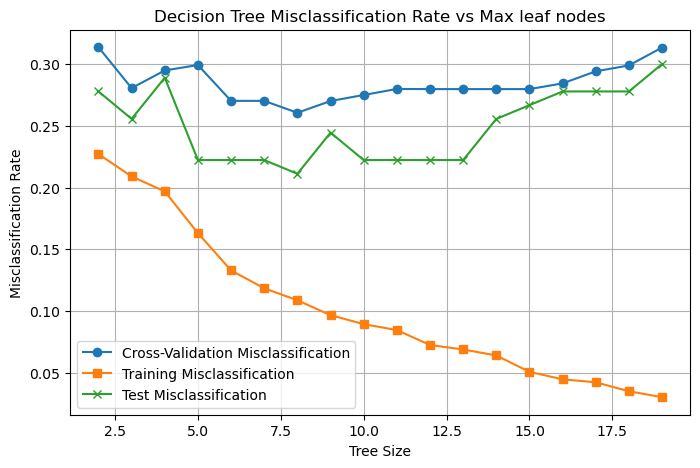

In [61]:
heart_data=pd.read_csv('Heart.csv')
heart_data=heart_data.drop('Unnamed: 0',axis=1)
heart_data = heart_data.dropna(subset=['Thal'])
heart_data = heart_data.dropna(subset=['Ca'])

# Define category orders based on medical severity
chestpain_order = ['asymptomatic','nonanginal', 'nontypical', 'typical']
thal_order = ['normal', 'fixed', 'reversable']

# Initialize ordinal encoder with category order
encoder = OrdinalEncoder(categories=[chestpain_order, thal_order])

# Apply encoding before splitting
heart_data[['ChestPain', 'Thal']] = encoder.fit_transform(heart_data[['ChestPain', 'Thal']])

# Convert to integer type for clarity
heart_data[['ChestPain', 'Thal']] = heart_data[['ChestPain', 'Thal']].astype(int)

X = heart_data.drop('AHD', axis=1)  # Features
y = heart_data['AHD']  # Target variable
(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=15)

max_leaf_nodes = list(range(2, 20))
misclassification_cv=[]
misclassification_training=[]
misclassification_test=[]

for i in max_leaf_nodes:
    clf=DTC(max_leaf_nodes=i,random_state=0)
    cv_results=cross_validate(clf,X_train,y_train,cv=5, return_train_score=True)
    
    misclassification_cv.append(1-np.mean(cv_results['test_score']))
    misclassification_training.append(1-np.mean(cv_results['train_score']))

    clf.fit(X_train,y_train)
    test_acc=clf.score(X_test,y_test)
    misclassification_test.append(1-test_acc)
    

print(misclassification_cv)
print(misclassification_training)
print(misclassification_test)
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(max_leaf_nodes, misclassification_cv, marker='o', linestyle='-', label="Cross-Validation Misclassification")
plt.plot(max_leaf_nodes, misclassification_training, marker='s', linestyle='-', label="Training Misclassification")
plt.plot(max_leaf_nodes, misclassification_test, marker='x', linestyle='-', label="Test Misclassification")
plt.xlabel("Tree Size")
plt.ylabel("Misclassification Rate")
plt.title("Decision Tree Misclassification Rate vs Max leaf nodes")
plt.legend()
plt.grid()
plt.show()

Bagging - Lecture
Bagging = Bootstrap aggregation. Why bootstrap? More observations = reduced variance. But why is this allowed?
According to chat gpt we do this in decision trees (high variance models), which is true. Whereas regression models are typically lower variance. 
We;re averaging many predictions!
Typically # of trees doesn't overfit (test error doesn't go up). Very interesting. averageing overfit models still creates a smooth, stable ensemble. Also reduced variance.

In OOB estimation, roughly 2/3 is used in a bagged tree. 1/3 observations are not used to fit a bagged tree, used as OOB. So we we naturally have validation. Better computationally!!
"The resulting OOB error is a valid
estimate of the test error for the bagged model, since the response for each
observation is predicted using only the trees that were not fit using that
observation."
Also we see random forest decreases to stable faster than bagged trees. Random forest Decorrelates the trees! Due to random sample of predictors. 
Random forest, parameter subset, m ~= sqrt(p)

How its useful for variable importance:

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\jhuang\AppData\Loca

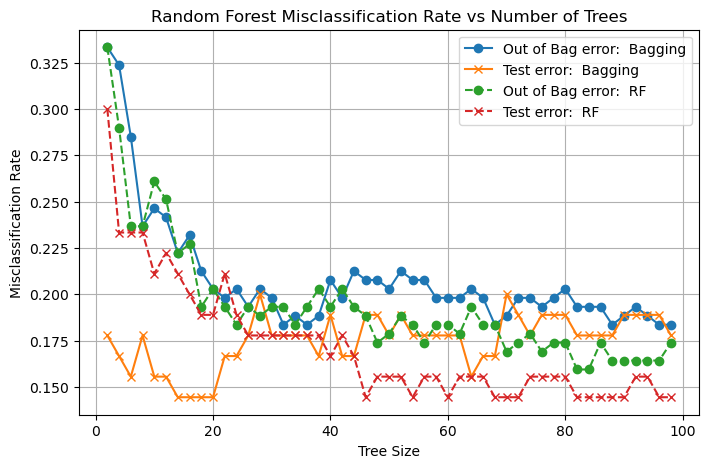

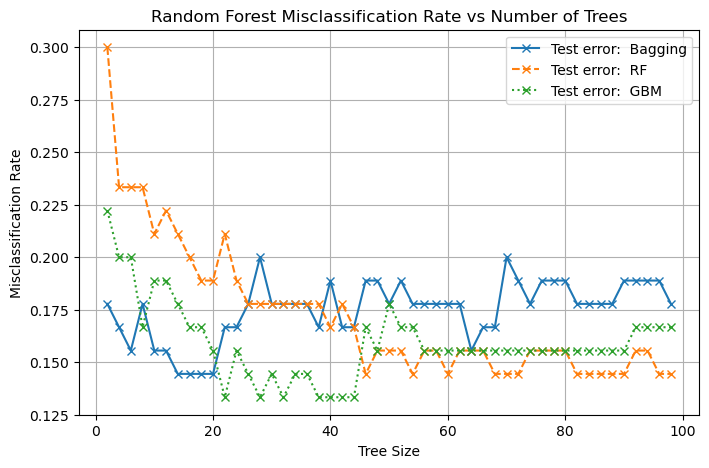

In [76]:

heart_data=pd.read_csv('Heart.csv')
heart_data=heart_data.drop('Unnamed: 0',axis=1)
heart_data = heart_data.dropna(subset=['Thal'])
heart_data = heart_data.dropna(subset=['Ca'])

# Define category orders based on medical severity
chestpain_order = ['asymptomatic','nonanginal', 'nontypical', 'typical']
thal_order = ['normal', 'fixed', 'reversable']

# Initialize ordinal encoder with category order
encoder = OrdinalEncoder(categories=[chestpain_order, thal_order])

# Apply encoding before splitting
heart_data[['ChestPain', 'Thal']] = encoder.fit_transform(heart_data[['ChestPain', 'Thal']])

# Convert to integer type for clarity
heart_data[['ChestPain', 'Thal']] = heart_data[['ChestPain', 'Thal']].astype(int)

X = heart_data.drop('AHD', axis=1)  # Features
y = heart_data['AHD']  # Target variable
(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=15)

num_trees = list(range(2,100,2))
error_oob_bag=[]
error_training_bag=[]
error_test_bag=[]

error_oob_rf=[]
error_training_rf=[]
error_test_rf=[]

error_oob_gbm=[]
error_test_gbm=[]

for i in num_trees:
    bagg=RFC(n_estimators=i,random_state=0,max_features=None,oob_score=True, )
    bagg.fit(X_train,y_train)

    oob_error=1-bagg.oob_score_
    error_oob_bag.append(oob_error)
    train_acc=accuracy_score(y_train,bagg.predict(X_train))
    error_training_bag.append(1-train_acc)

    test_acc=accuracy_score(y_test,bagg.predict(X_test))
    error_test_bag.append(1-test_acc)
for i in num_trees:
    rfg=RFC(n_estimators=i,random_state=0,max_features='sqrt',oob_score=True, )
    rfg.fit(X_train,y_train)

    oob_error=1-rfg.oob_score_
    error_oob_rf.append(oob_error)
    train_acc=accuracy_score(y_train,rfg.predict(X_train))
    error_training_rf.append(1-train_acc)

    test_acc=accuracy_score(y_test,rfg.predict(X_test))
    error_test_rf.append(1-test_acc)
for i in num_trees:
    gbm = GBC(n_estimators=i, learning_rate=0.1, random_state=42, subsample=0.8)
    gbm.fit(X_train,y_train)

    oob_error=1-gbm.oob_score_
    error_oob_gbm.append(oob_error)
    test_acc=accuracy_score(y_test,gbm.predict(X_test))
    error_test_gbm.append(1-test_acc)

plt.figure(figsize=(8, 5))
plt.plot(num_trees, error_oob_bag, marker='o', linestyle='-', label="Out of Bag error:  Bagging")
plt.plot(num_trees, error_test_bag, marker='x', linestyle='-', label="Test error:  Bagging")
plt.plot(num_trees, error_oob_rf, marker='o', linestyle='--', label="Out of Bag error:  RF")
plt.plot(num_trees, error_test_rf, marker='x', linestyle='--', label="Test error:  RF")
plt.xlabel("Tree Size")
plt.ylabel("Misclassification Rate")
plt.title("Random Forest Misclassification Rate vs Number of Trees")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(num_trees, error_test_bag, marker='x', linestyle='-', label="Test error:  Bagging")
plt.plot(num_trees, error_test_rf, marker='x', linestyle='--', label="Test error:  RF")
plt.plot(num_trees, error_test_gbm, marker='x', linestyle=':', label="Test error:  GBM")
plt.xlabel("Tree Size")
plt.ylabel("Misclassification Rate")
plt.title("Random Forest Misclassification Rate vs Number of Trees")
plt.legend()
plt.grid()
plt.show()



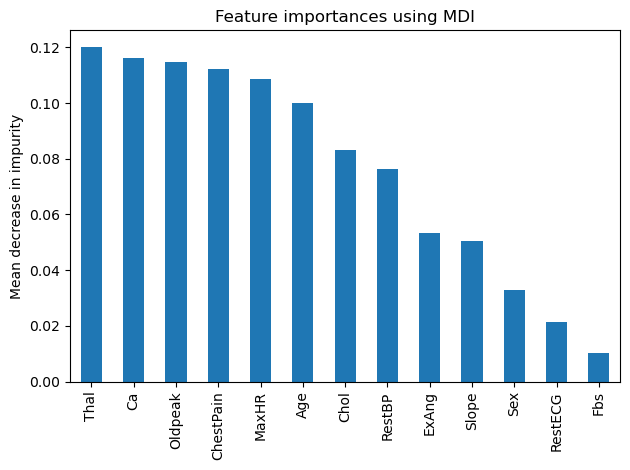

In [ ]:
rfg=RFC(n_estimators=40,random_state=0,max_features='sqrt',oob_score=True, )
rfg.fit(X_train,y_train)

feature_names=X.columns
importances = rfg.feature_importances_

feature_importance=pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Lecture - Boosting
Start with Adaboost

RF:
1. Trees
2. equal says
3. trees are independent.

Adaboost:
1. Stumps
2. some stumps worth more
3. stump takes into accout previous stumps.

Determine first stump. Is the variable that has the lowest gini index.
Then determine how much say it will have in the final classification.
Based on Total error rate of split, find amount of say. Then use amount of say to weight sample.
Can use weighted gini function and use it with sample weights. ortherwise just sample weights as a probability and make a new dataset that reflects those weights.

For classification. total amount of say for all the stumps for 1 class, that determines class. 

Gradient Boost.
Usually predetermined. Max leaves = 4 in this case. Predict the residuals.

In regression settings:
Start with average value.
Loop: 
    Calculate residuals.
    Predict these residuals with a tree. For leaves with multiple values, replace with average.
    Now we predict values = avg value + alpha*(tree). Learning rate acts as the 'gradient.' Small steps in right direction. lower variance.
Go until residuals stop or hit max number of trees


1. Start with leaf.
2. Build tree, based on previous 

| Syntax      | Description |
| ----------- | ----------- |
| Header      | Title       |
| Paragraph   | Text        |


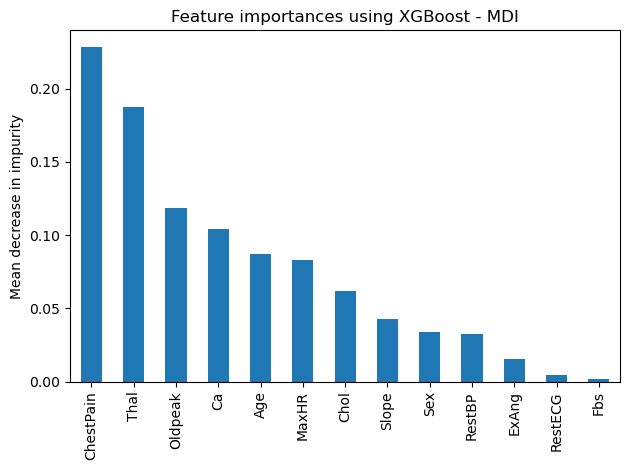

In [68]:
heart_data=pd.read_csv('Heart.csv')
heart_data=heart_data.drop('Unnamed: 0',axis=1)
heart_data = heart_data.dropna(subset=['Thal'])
heart_data = heart_data.dropna(subset=['Ca'])


# Define category orders based on medical severity
chestpain_order = ['asymptomatic','nonanginal', 'nontypical', 'typical']
thal_order = ['normal', 'fixed', 'reversable']

# Initialize ordinal encoder with category order
encoder = OrdinalEncoder(categories=[chestpain_order, thal_order])

# Apply encoding before splitting
heart_data[['ChestPain', 'Thal']] = encoder.fit_transform(heart_data[['ChestPain', 'Thal']])

# Convert to integer type for clarity
heart_data[['ChestPain', 'Thal']] = heart_data[['ChestPain', 'Thal']].astype(int)

X = heart_data.drop('AHD', axis=1)  # Features
y = heart_data['AHD']  # Target variable
(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=15)

gbm = GBC(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)
importances = gbm.feature_importances_

feature_importance=pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using XGBoost - MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Lab

In [133]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
"Yes","No")

model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

print(D)

     CompPrice  Income  Advertising  Population  Price  ShelveLoc[Good]  \
0          138      73           11         276    120              0.0   
1          111      48           16         260     83              1.0   
2          113      35           10         269     80              0.0   
3          117     100            4         466     97              0.0   
4          141      64            3         340    128              0.0   
..         ...     ...          ...         ...    ...              ...   
395        138     108           17         203    128              1.0   
396        139      23            3          37    120              0.0   
397        162      26           12         368    159              0.0   
398        100      79            7         284     95              0.0   
399        134      37            0          27    120              1.0   

     ShelveLoc[Medium]  Age  Education  Urban[Yes]  US[Yes]  
0                  0.0   42         1

0.47106470626493574


[Text(0.5, 0.875, 'ShelveLoc[Good] <= 0.5\nentropy = 0.977\nsamples = 400\nvalue = [236, 164]'),
 Text(0.25, 0.625, 'Price <= 92.5\nentropy = 0.894\nsamples = 315\nvalue = [217, 98]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Income <= 57.0\nentropy = 0.887\nsamples = 46\nvalue = [14, 32]'),
 Text(0.0625, 0.125, 'entropy = 0.881\nsamples = 10\nvalue = [7, 3]'),
 Text(0.1875, 0.125, 'entropy = 0.711\nsamples = 36\nvalue = [7, 29]'),
 Text(0.375, 0.375, 'Advertising <= 13.5\nentropy = 0.804\nsamples = 269\nvalue = [203, 66]'),
 Text(0.3125, 0.125, 'entropy = 0.687\nsamples = 224\nvalue = [183, 41]'),
 Text(0.4375, 0.125, 'entropy = 0.991\nsamples = 45\nvalue = [20, 25]'),
 Text(0.75, 0.625, 'Price <= 135.0\nentropy = 0.767\nsamples = 85\nvalue = [19, 66]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'US[Yes] <= 0.5\nentropy = 0.523\nsamples = 68\nvalue = [8, 60]'),
 Text(0.5625, 0.125, 'entropy = 0.937\nsamples = 17\nvalue = [6, 11]'),
 Text(0.6875, 0.125, 'entropy = 0.

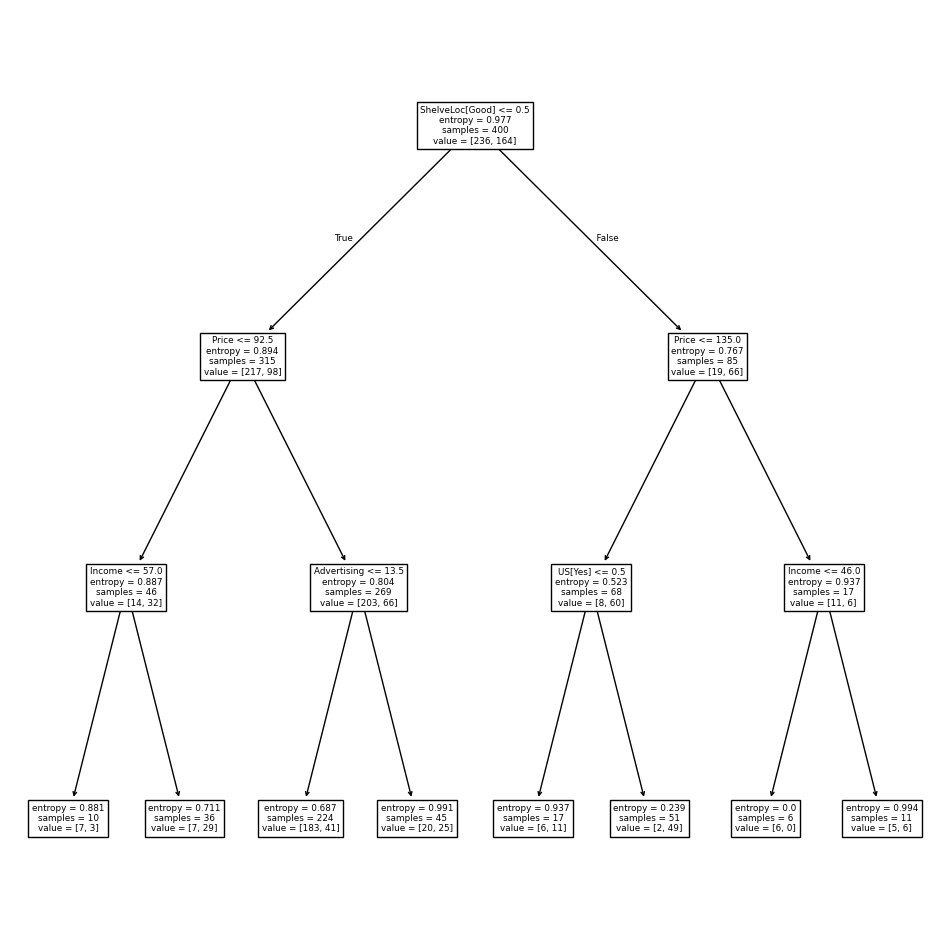

In [173]:
clf = DTC(criterion='entropy',max_depth=3,random_state=0)
clf.fit(X, High)
accuracy_score(High, clf.predict(X))

resid_dev = np.sum(log_loss(High , clf.predict_proba(X)))
print(resid_dev)

ax = plt.subplots(figsize=(12,12))[1]
plot_tree(clf ,feature_names=feature_names,ax=ax)


What's the test error? without depth limit. Its 0.735 with 50% split. 

In [ ]:
(X_train ,X_test ,High_train ,High_test) = train_test_split(X,High,test_size=0.5,random_state=0)
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train , High_train)
print(accuracy_score(High_test , clf.predict(X_test)))
print(clf.tree_.n_leaves)


0.735
35


lowest cv gives 0.685. 

In [176]:
ccp_path = clf.cost_complexity_pruning_path(X_train , High_train)
kfold = KFold(10,random_state=1,shuffle=True)
grid = GridSearchCV(clf,{'ccp_alpha': ccp_path.ccp_alphas},refit=True ,cv=kfold,scoring='accuracy')
grid.fit(X_train , High_train)
grid.best_score_

0.685

with ccp pruning. we got 0.72 on test set. removed 5 leaves and got slightly worse.

30
0.72
Truth      No  Yes
Predicted         
No         94   32
Yes        24   50


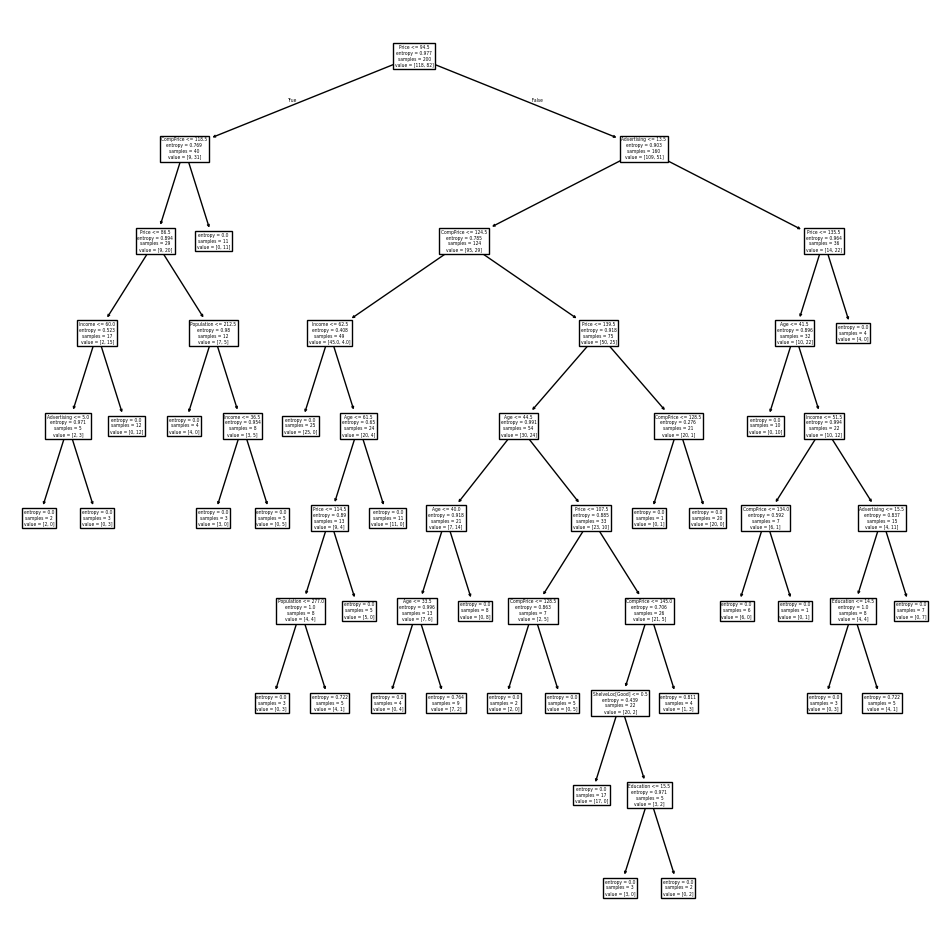

In [168]:
ax = plt.subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_ ,feature_names=feature_names ,ax=ax);
print(best_.tree_.n_leaves)
print(accuracy_score(High_test,best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),High_test)
print(confusion)

try plotting score by # leaves, alpha, etc to see how it works.

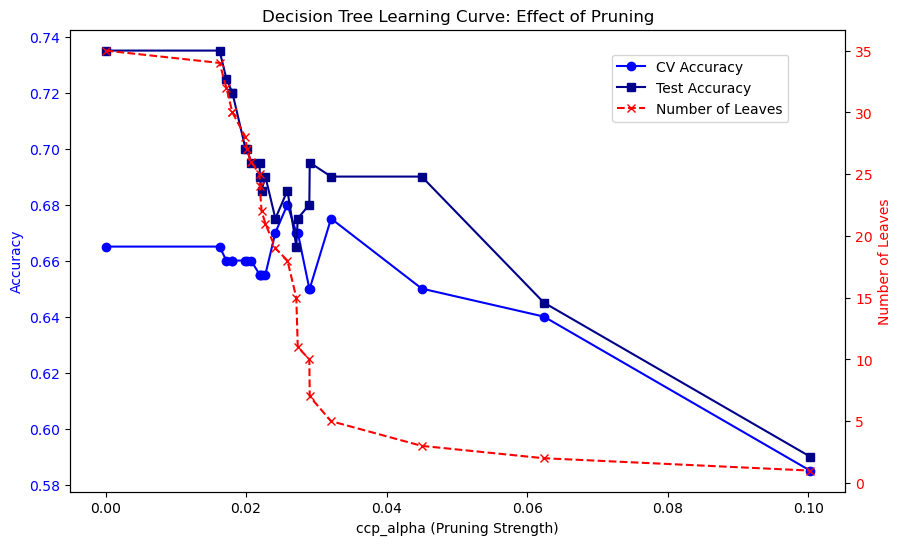

In [181]:
X_train ,X_test ,High_train ,High_test = train_test_split(X,High,test_size=0.5,random_state=0)
ccp_path = clf.cost_complexity_pruning_path(X_train , High_train)
cv_scores = []  # Cross-validation accuracy
test_scores = []  # Test set accuracy
num_leaves = []  # Number of leaves
ccp_alphas=ccp_path.ccp_alphas

for alpha in ccp_alphas:
    pruned_clf=DTC(criterion='entropy',ccp_alpha=alpha,random_state=0)
    cv_score=np.mean(cross_val_score(pruned_clf,X_train,High_train,cv=5,scoring='accuracy'))
    cv_scores.append(cv_score)

    pruned_clf.fit(X_train,High_train)
    test_score=pruned_clf.score(X_test,High_test)
    test_scores.append(test_score)
    num_leaves.append(pruned_clf.tree_.n_leaves)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("ccp_alpha (Pruning Strength)")
ax1.set_ylabel("Accuracy", color="blue")
ax1.plot(ccp_alphas, cv_scores, marker="o", linestyle="-", label="CV Accuracy", color="blue")
ax1.plot(ccp_alphas, test_scores, marker="s", linestyle="-", label="Test Accuracy", color="darkblue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Number of Leaves", color="red")
ax2.plot(ccp_alphas, num_leaves, marker="x", linestyle="--", label="Number of Leaves", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.legend(loc="upper right", bbox_to_anchor=(0.85,0.85))
plt.title("Decision Tree Learning Curve: Effect of Pruning")
plt.show()

testing for overfit? it seems like the tree stabilizes at a certain_depth around 9. so early on (small tree) theres some bias. but then it doesnt show signs of overfitting at large tree levels. signifies the dataset is large enough, and maybe there's already structure in the dataset. Could even test to see if there is some implicit regularization being set (min_sample_split, min_samples_leaf), etc

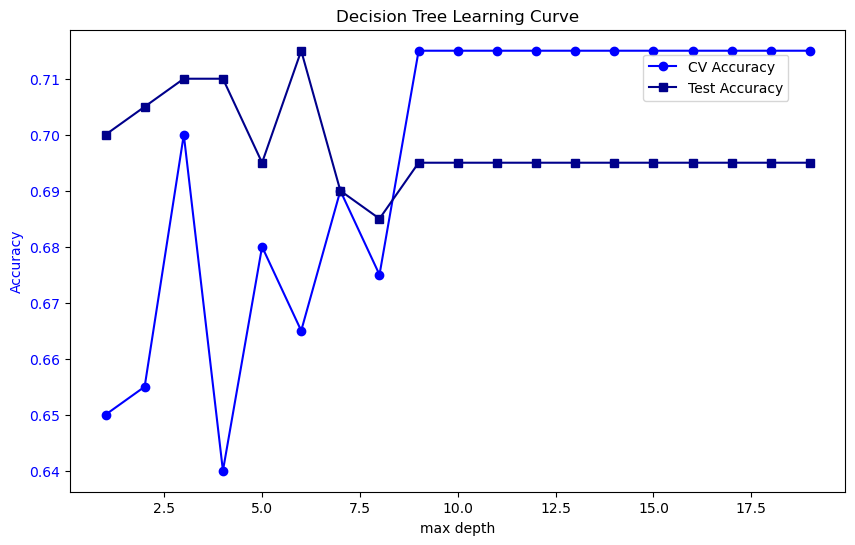

In [191]:
X_train ,X_test ,High_train ,High_test = train_test_split(X,High,test_size=0.5,random_state=1265)
cv_scores = []  # Cross-validation accuracy
test_scores = []  # Test set accuracy
max_depth = np.arange(1,20)  # Number of leaves

for depth in max_depth:
    pruned_clf=DTC(criterion='entropy',max_depth=depth,random_state=0)
    cv_score=np.mean(cross_val_score(pruned_clf,X_train,High_train,cv=5,scoring='accuracy'))
    cv_scores.append(cv_score)

    pruned_clf.fit(X_train,High_train)
    test_score=pruned_clf.score(X_test,High_test)
    test_scores.append(test_score)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("max depth")
ax1.set_ylabel("Accuracy", color="blue")
ax1.plot(max_depth, cv_scores, marker="o", linestyle="-", label="CV Accuracy", color="blue")
ax1.plot(max_depth, test_scores, marker="s", linestyle="-", label="Test Accuracy", color="darkblue")
ax1.tick_params(axis="y", labelcolor="blue")


fig.legend(loc="upper right", bbox_to_anchor=(0.85,0.85))
plt.title("Decision Tree Learning Curve")
plt.show()

In [ ]:
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "ccp_alpha": [0.0, 0.01, 0.1]
}

Applied Exercise 8. 